# PreLab 2 Solving Ordinary Differential Equations Numerically and One-node Network Motifs

> Yujia, Ethan, and Vincent adapted from materials developed by Diane and Elizabeth
> 
> 2024/3/28 (Week 2)

Edit this document directly. As you go through the notebooks you will find numbered questions. Please answer in the cells provided. 
   
This is an individual assignment, but you are allowed (encouraged!) to work together in groups and discuss coding and
answers. That said, you are responsible for all the material in this laboratory assignment. **DO NOT
COPY from anyone that you work with.** You are **NOT** allowed to share code. You need to write the code
and answer the questions yourself. Try the coding yourself first before seeking help.

<div class="alert alert-info" role="alert">
    
__Total Points 15__

__Due: 3/28 Thursday 1:30 pm__ 
</div>

If you have any questions, please do not hesitate to ask. You can find the emails and office hours of the instructors and TAs on Canvas. Best of luck!


### How to solve differential equations? A video demo

In the prelab video we learned how to use odeint to solve differential equations. We looked at the simple example, a pool of protein that is degraded according to the equation:    

$$\frac{dX}{dt} = -\alpha X \tag{1}$$

![degradation](https://github.com/dschnitkey/BIOS20236/blob/main/prelab2_degradation.png?raw=true)   
    
This description of the system doesn't directly tell us how [X] changes over time. We might want to know what [X] is after a long period of time (for a system like this with only degradation you would imagine [X] will go to 0), and how long it takes to get to steady state. To answer such questions, we need to **integrate** so we get an equation for X as a function of time, rather than  $dX/dt$ as a function of [X].   
    
As we discussed in lecture, some systems (including this one) can be solved analytically. Eq. 1 solves to
   
$$X(t) = X_0e^{-\alpha t}\tag{2}$$   

Where $X_0$ is the initial condition, i.e. the concentration of X at time 0.
Indeed, the concentration of X will degrade exponentially to 0 as shown in the figure below

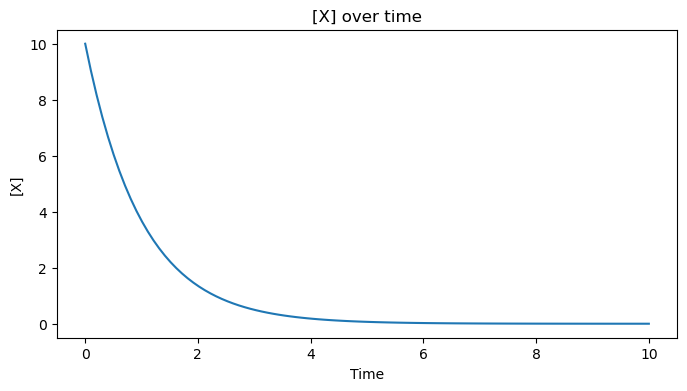

In [128]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt

x0 = 10
alpha = 1
t = np.linspace(0,10,100)
x_analytical = x0*np.exp(-alpha*t)

plt.figure(figsize = [8,4])
plt.plot(t,x_analytical,'-')
plt.xlabel("Time")
plt.ylabel("[X]")
plt.title("[X] over time");

We will be working with equations that cannot be solved analytically, so we will instead solve them computationally. 
Computers can approximate the solution $X(t)$ using the derivative $dX/dt$.    

The idea is very simple! Recall that by definition a derivative is given by

$$\left.\frac{d}{dt}X(t)\right\vert_{t_0} = \frac{X(t_1) - X(t_0)}{t_1 - t_0}$$ 

in the limit where $(t_1 - t_0)$ is infinitestimally small.

So if you know $dX/dt$ evaluated at $t_0$, and your starting concentration of $X$, you can take a small step forward

$$X(t_1) = X(t_0) + \left.\frac{dX}{dt}\right\vert_{t_0}\cdot(t_1 - t_0) $$ 

Your new $X$ is the previous $X$ plus the derivative times your step size. You can repeat this over and over to estimate your curve. The smaller the step size the more accurate. 

The method is known as the _Euler method_. Modern differential equation integrators can pick the time interval in some smart way. They also divide each time interval into smaller ones and combine the derivatives at those intermediary time points. But these fancy algorithms all stem from this very simple idea by Euler.

The animation below shows how the interative process of evaluating the derivative $dX/dt$ and taking a step forward in $X$ can approximate the solution for Eq. 1.

![comp_int](https://github.com/dschnitkey/BIOS20236/blob/main/CompIntegrate2.gif?raw=true)

Lucky for us python has a function `odeint` which will do this for us. Let's learn how to use it. 


`odeint` belongs to scipy's integrate package: [https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html)

fun fact: scipy is short for "scientfic python" and as a result is often pronounced "sie-pie". Similarly numpy is short for "numerical python" and is often pronounced "num-pie". I say often because some people will call them "skippy" and "numpy" which is honestly more fun.

To invoke `odeint` we will use the following form


```python
from scipy.integrate import odeint
output = odeint(func, y0, t, args=())
```
   
With the following arguments:

1. `y0` = your initial value of x. 
2. `t` = an _array_ going from 0 to tmax, where tmax is the total time you want to simulate   
3. `args` = remaining arguments our derivative needs. In this case, our derivative depends on $\alpha$.
   It must be a _tuple_, the unchangeable counterpart of a list.
5. `func` = a function that returns your derivative $dX/dt$ i.e. the right-hand side.
   
**It is important that your function be of the following form**:
    
```python
def func(x, t, arg1, arg2, ...):
    do something
    return dxdt
```
    
**the order of the arguments to func is very important** first, you must give it x, the value you are trying to integrate over, then is t 

**your derivitives need not use t in them, you still need to list it as an input to func**, then you can add your remaining inputs.
The interface is designed in this way to allow some ODEs to dependent explicitly on t. We won't meet any of those in this class

Let's solve the ODE (ordinary differential equation) given by Eq. 1 numerically by `odeint` and see if it agrees with the analytical solution

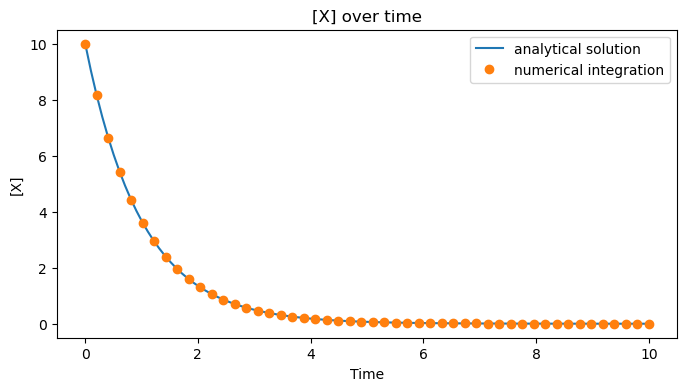

In [20]:
#rhs equation
def rhs_decay(x,t,alpha):
    return(-alpha*x)

#inital concentration
x0 = 10

#times to integrate over
times = np.linspace(0,10,50)

#arguments
alpha = 1

##arguments must be put in parenthesis like this (a tuple), even if there is only one!
args = (alpha,)

#call odeint
x_computational = odeint(rhs_decay, x0, times, args)

#plot our solution and compare to the analytical solution
plt.figure(figsize = [8,4])
plt.plot(t,x_analytical,'-', label = "analytical solution")
plt.plot(times,x_computational,'o', label = "numerical integration")
plt.xlabel("Time")
plt.ylabel("[X]")
plt.title("[X] over time")
plt.legend();

We see that `odeint` does a great job matching the true analytical solution! In this prelab and our lab, we will use `odeint` to solve more complex systems

## Part 1 Simply Regulated Gene Expression

In this homework assignment, you will learn how to write a script to solve three simple 1D - ODEs in Python (1D means only one chemical species, or one variable, is involved).

We will learn how to invoke Python’s built-in ODE solver and plot the results. Understanding the dynamics of a simply regulated gene is crucial to studying the more complex systems we will study later, including the circuit that controls competence in Bacillus subtilis.

![simplyreggene](https://github.com/dschnitkey/BIOS20236/blob/aed523ba698b3634bd26284e91ef32278ee2e154/prelab2_simplyreggene.png?raw=true)


In [1]:
# Import modules
from scipy.integrate import odeint
import numpy as np
import math
import matplotlib.pyplot as plt

<h3 style="color:blue;">Tasks for Part 1</h3>
    
__1.1__ Define the right-hand-side (RHS) of the ordinary differential equation (ODE) that follows the simple scheme shown in the figure above.

The RHS consists of a 0th order production term and a 1st order elimination term. Namely

$$
\frac{dX}{dt} = \beta - \alpha X
$$

In [1]:
# your solution 1.1



__1.2__ Solve and plot the solution for the simply regulated gene given initial condition $X_0 = 0$

Please include axis labels on your graph.
You will use the set of parameters shown below (also included in your code chunk).
This is crucial because you will compare different schemes of gene regulation.
The given set of parameters make sure that the steady state is consistent.

__Reaction parameters__

$\beta = 2$ in units of concentration/time

$\alpha = 1$ in units of 1/time

Recall what you've learned from the 2nd lecture. Think aobut this: What is the _steady state_ and the _response time_ of the system?
Does your plot agree with your expectation? You don't have to write your answer down.

In [2]:
beta = 2
alpha = 1

# your solution 1.2



__1.3__ Plot a horizontal dashed line on your graph that represents 1⁄2 way to steady state. 

Recall that the steady state is given by

$$
X_{ss} = \frac{\beta}{\alpha}
$$

Call `plt.axhline` or `plt.axvline` to plot a horizontal or vertical line. E.g.

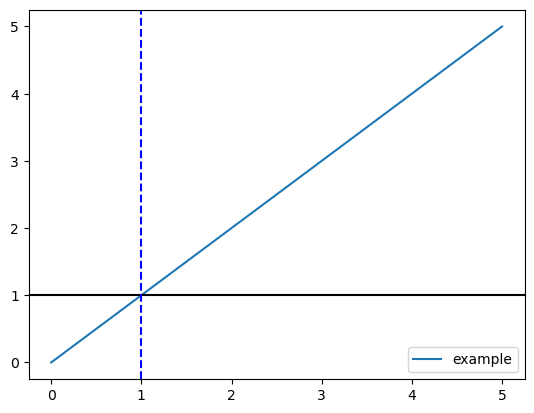

In [28]:
plt.figure()
plt.plot(range(6), range(6), label="example")
plt.axhline(y = 1, color="black")
plt.axvline(x = 1, linestyle="dashed", color="blue")
plt.legend();

In [3]:
# your solution 1.3



__1.4__ Calculate the response time of the system. The response time $\tau_{1/2}$ is given by

$$
\tau_{1/2} = \frac{\ln{2}}{\alpha}
$$

In [4]:
# your solution 1.4



__1.5__ Plot the response time as a vertical dashed line onto your previous plot in 1.3

You can see the crossing of the threshold value (1/2 way to steady state) and the calculated response time on your graph.

In [5]:
# your solution 1.5



## Part 2 Negatively Autoregulated Gene Expression

Consider the negatively autoregulated gene circuit below:

![negreggene](https://github.com/dschnitkey/BIOS20236/blob/main/prelab2_negativelyautoregulatedgene.png?raw=true)

Described by the ODE:

$$ 
\frac{dX}{dt} = \beta _0 + \beta \frac{K^n}{X^n + K^n}- \alpha X
$$

Notice that we have a basal production term plus a negative regulated production term involving a repressive Hill function.
For consistency please use the set of reaction parameters below

$$
\begin{align}
\beta_0 &= 0.6\\
\beta &= 2.8\\
K &= 2\\
n &= 2\\
\alpha &= 1
\end{align}
$$


<h3 style="color:blue;">Tasks for Part 2</h3>

__2.1__ Create a global function that contains the RHS of the ODE. 

Solve and plot the solution for the negatively autoregulated gene given initial condition $X_0 = 0$. 
Please label your axes.

In [6]:
beta0 = 0.6
beta = 2.8
K = 2.
n = 2.
alpha = 1.

# your solution 2.1



__2.2__ Plot a horizontal dashed line on your graph that represents 1⁄2 way to steady state. 

The parameters were chosen in a way to make sure that steady state is still 2.

In [7]:
# your solution 2.2



__2.3__ Find the response time of the negative autoregulated gene model starting from $X = 0$

By definition, the response time is the the time for the system to reach 1/2 of its steady state, which is 1 in this case.
Your task is to find numerically the time when $X(t)$ reaches 1.

Please first run the cell below to define the function `find_t_by_x`. The function allows you to find the first time point when $X$ reaches a certain value given the solution you just found numerically.

In [129]:
# sol: the solution
# t: time points where the solution is given. t has to be of the same length as sol
# x_find: X(t) at the time point you want to find

def find_t_by_x(sol, t_vec, x_find):
    md = 1e6    # min distance
    t_find = -1
    for t, x in zip(t_vec, sol):
        md_new = (x - x_find)**2
        if md_new < md:
            md = md_new
            t_find = t
    return t_find

In [8]:
# your solution 2.3



An approximation for the responsetime $\tau_{1/2}$ when the Hill function is steep is 

$$
\tau_{1/2} \approx \frac{K}{2(\beta + \beta_0)}
$$

I won't go through the detail of how we land on it, but if you are interested, there is a nice and simple intuition in Uri Alon's book Introduction to Systems Biology (2020) Chapter 2.4.

Such approximation gives $\tau_{1/2} = 0.29$. Though here we have the Hill coefficient $n = 2$ and the approximation may not be so good.
Still, you can use this value as a quick sanity check.

Also, I want you to appreciate that the response time of a negatively autoregulated gene can be tuned by its promoter activity, reflected as $\beta + \beta_0$ here.
Recall that we've learned in the second class that the response time of a simply regulated gene is only dependent on the degradation rate but not the production rate.
By negative autoregulation biology now has a different knob to turn.


__2.4__ Plot the response time as a vertical dashed line on your previous plot in 2.2

You should see the crossing of the threshold value (1/2 way to steady state) and the calculated response time on your graph.

In [9]:
# your solution 2.4



## Part 3 Positively Autoregulated Gene Expression

Consider the positively autoregulated gene circuit below:

![posreggene](https://github.com/dschnitkey/BIOS20236/blob/main/prelab2_posautoregulatedgene.png?raw=true)

Described by the ODE:

$$ 
\frac{dX}{dt} = \beta _0 + \beta \frac{X^n}{X^n + K^n}- \alpha X
$$

For consistency please use the set of reaction parameters below

$$
\begin{align}
\beta_0 &= 0.6\\
\beta &= 2.8\\
K &= 2\\
n &= 2\\
\alpha &= 1
\end{align}
$$

<h3 style="color:blue;">Tasks for Part 3</h3>

__3.1__ First, create a new function that defines the RHS for the above positively autoregulated gene motif.

Then, solve and plot the solution for the positively autoregulated gene given initial condition $X_0 = 0$. 
Please label your axes.

In [10]:
beta0 = 0.6
beta = 2.8
K = 2.
n = 2.
alpha = 1.

# your solution 3.1



__3.2__ First, plot a horizontal line on your graph that represents 1⁄2 way to steady state.
Keep in mind that the steady state is still 2.

Then, plot a vertical line representing the response time you found using the `find_t_by_x` function. Print the response time

In [11]:
# your solution 3.2



### Compare the Response Times for the Three 1-D Gene Motifs

Finally, we will do what people may call a _mathematically controlled experiment_.
Among the three gene expression models/motifs that you have explored, you may have noticed that
all of them share the same steady state and degradation rate.
The production rate for the negatively and positively autoregulated gene is bumped up from that
of the simply regulated gene to compensate for the steady state.

Here we ask __if the response time is different in different motifs__. 
If so, biology may find these motifs helpful to speed up or slow down certain gene expression.

__3.3__ Plot the simply regulated, negatively, and positively autoregulated motifs on the same graph (3 lines). 
Rank the three motifs in ascending order of response time.

Think about why different autoregulation schemes will affect the response time differently. You don't have to write down the answer.

In [12]:
# your solution 3.3



__Please edit this cell to add your answer__

